<a href="https://colab.research.google.com/github/namanmeena/covid19-classification-using-xray/blob/master/Covid19_Classification_Using_XRay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FastAI - COVID19 Classification using Chest XRay

Inspired by [Adrian Rosebrock's blog - 'Detecting COVID-19 in X-ray images with Keras, TensorFlow, and Deep Learning
'](https://www.pyimagesearch.com/2020/03/16/detecting-covid-19-in-x-ray-images-with-keras-tensorflow-and-deep-learning/)

## Disclaimer:
**The methods and techniques used in this post are meant for educational purposes only. This is not a scientifically rigorous study, nor will it be published in a journal. This article is for people who are interested in (1) Computer Vision/Deep Learning and want to learn via practical, hands-on methods and (2) are inspired by current events. I kindly ask that you treat it as such.**

## About FastAI
Fast.ai is a brainchild of Rachel Thomas and Jeremy Howard. The idea behind FastAI is to democratize AI to reach people from all domains.

Keras is another library, built on top of TensorFlow and therefore provides abstraction over Google's TensorFlow. Although, being very powerful, it still requires you to write a lot of lines of code to get things done. Therefore, to quickly get started with experimentation, FastAI is good and my personal preference.

## About Dataset

The dataset used in this use-case is from [Kaggle - 'COVID-19 RADIOGRAPHY DATABASE (Winner of the COVID-19 Dataset Award)
'](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database)


### We are going to use kaggle api to download the dataset

In [ ]:
# Installing Kaggle api
!pip install kaggle

## Script to download and extract dataset

In [72]:
%%bash

token="" # Put your token
token_dir="/root/.kaggle"
competition="covid19-xray"
dataset_path="kaggle_datasets"
competition_dataset_path="$dataset_path/$competition"

# Removing existing dir
rm -rf $token_dir
rm -rf $competition_dataset_path

# Creating directories
mkdir -p $token_dir
mkdir -p $competition_dataset_path

# Placing kaggle token
echo $token > $token_dir/kaggle.json

# Giving permission to token
chmod 600 $token_dir/kaggle.json

# Downloading dataset using kaggle
kaggle datasets download -d tawsifurrahman/covid19-radiography-database -p $competition_dataset_path

# Extracting dataset
unzip -qq kaggle_datasets/covid19-xray/covid19-radiography-database.zip -d $competition_dataset_path

# Cleanup some files as they may interfere with reading fastai
rm kaggle_datasets/covid19-xray/'COVID-19 Radiography Database'/*.xlsx
rm kaggle_datasets/covid19-xray/'COVID-19 Radiography Database'/*.txt

100%|##########| 1.15G/1.15G [00:09<00:00, 136MB/s]


In [71]:
!ls -l 'kaggle_datasets/covid19-xray/COVID-19 Radiography Database'

total 128
drwxr-xr-x 2 root root 12288 Aug 16 15:34  COVID-19
drwxr-xr-x 2 root root 49152 Aug 16 15:34  NORMAL
drwxr-xr-x 2 root root 69632 Aug 16 15:34 'Viral Pneumonia'


Let's see how many files are present in each directory. The number is 1 less than actual number of files.


In [8]:
%%bash
echo "Covid19 files: " `ls -l kaggle_datasets/covid19-xray/'COVID-19 Radiography Database'/COVID-19 | wc -l`
echo "NORMAL files: " `ls -l kaggle_datasets/covid19-xray/'COVID-19 Radiography Database'/NORMAL | wc -l`
echo "Viral Pneumonia: " `ls -l kaggle_datasets/covid19-xray/'COVID-19 Radiography Database/Viral Pneumonia' | wc -l`

Covid19 files:  220
NORMAL files:  1342
Viral Pneumonia:  1346


In [14]:
BASE_PATH = "kaggle_datasets/covid19-xray"
PROJECT_PATH = f"{BASE_PATH}/COVID-19 Radiography Database"

## Let's Start

In [15]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [16]:
from fastai.vision import *
from fastai.metrics import *

In [17]:
## Suppressing warnings from FastAI warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

## Checking GPU assigned
It will help us to find out its memory which will help in deciding the batch size.

In [19]:
!nvidia-smi

Sun Aug 16 14:30:07 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8    10W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [21]:
bs=64

## Creating Image DataBunch
We are not going to augment the data since it is a chest XRay and augmenting it may lose the actual information that the xray conveys. We can use some augmentation like brightness, zooming and crop but for this use case I'm going to skip that.

If you feel the need to augment, you can do them and refer to the [documentation](https://docs.fast.ai/vision.transform.html#get_transforms)

In [26]:
data = (ImageList.from_folder(PROJECT_PATH) \
    # Splitting dataset with 80% for traininig and 20% for validation 
    .split_by_rand_pct(seed=99, valid_pct=0.2) \
    # Using labels from folders
    .label_from_folder() \
    # Resizing without augmentation
    .transform(size=224) \
    # Creating a DataBunch with the batch size
    .databunch(bs=bs) \
    # Normalizing the colors with ImageNet dataset's avg RGB stats
    .normalize(imagenet_stats))

data.save("covid19_data.pkl")

In [ ]:
# Will need if the
# del data
# del learn

In [28]:
# FastAI provides you the flexibility to change the batch size on loading the DataBunch from disk.
bs=64
data = load_data(PROJECT_PATH, "covid19_data.pkl", bs=bs)
data

ImageDataBunch;

Train: LabelList (2324 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Viral Pneumonia,Viral Pneumonia,Viral Pneumonia,Viral Pneumonia,Viral Pneumonia
Path: kaggle_datasets/covid19-xray/COVID-19 Radiography Database;

Valid: LabelList (581 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Viral Pneumonia,Viral Pneumonia,Viral Pneumonia,NORMAL,Viral Pneumonia
Path: kaggle_datasets/covid19-xray/COVID-19 Radiography Database;

Test: None

## Visualizing the DataBunch created

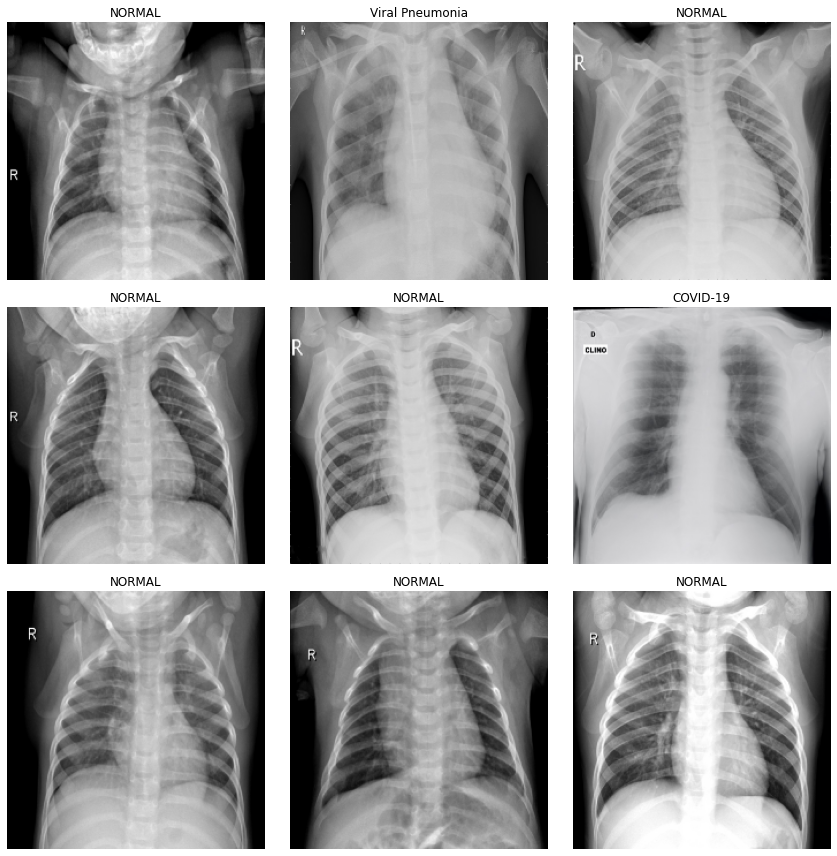

In [69]:
data.show_batch(rows=3, figsize=(12, 12))

## Create Learner with Resnet50

In [37]:
doc(Recall)

In [39]:
# Metrics to be used during validation
fscore = FBeta(average='macro', beta=1)
precision = Precision(average='macro')
recall = Recall(average="macro")

# Creating Learner
learn = cnn_learner(data, models.resnet50, metrics=[accuracy, fscore, precision, recall])

In [40]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

### Warming up 
We will warm up and train for 1 epoch so the newly added layers after resnet50 are not randomly initialized when we train by unfreezing the resent50 model.

In [41]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,f_beta,precision,recall,time
0,0.517296,2.601442,0.612737,0.507373,0.635255,0.618004,01:28


### Saving Stage - 1 (WarmUp)

In [42]:
learn.save("stage-1")

In [43]:
def plot_cf(learner):
  """
  Plotting the Confusion matrix using `ClassificationInterpretation` from FastAI
  args:
    learner - the learner trained
  """
  interp = ClassificationInterpretation.from_learner(learner)

  losses,idxs = interp.top_losses()

  len(data.valid_ds)==len(losses)==len(idxs)
  interp.plot_confusion_matrix(figsize=(6,6))

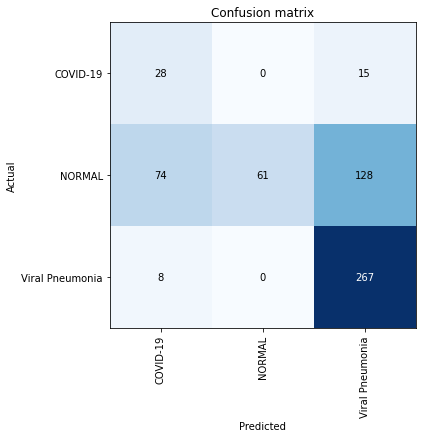

In [45]:
plot_cf(learn)

## Stage - 2
Loading Stage - 1 and Unfreeze the resnet50 model.
We will now train the whole model, but before that we will use `lr_find` method on learner to use an optimal learning rate.

In [46]:
learn.load("stage-1")
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


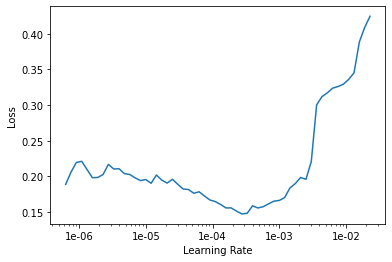

In [47]:
learn.lr_find()
learn.recorder.plot()

## Checkpoint Callback

We are going to use a callback to save our model after each epoch. It will help us restore the model to a previous state if it starts to overfit.

In [49]:
learner_callbacks = [callbacks.SaveModelCallback(learn, every='epoch', monitor='accuracy', name='stage-2')]
lr = slice(2e-6,1e-2/(4.3**2))
lr

slice(2e-06, 0.0005408328826392645, None)

In [50]:
learn.fit_one_cycle(5, max_lr=lr, wd=1e-1, callbacks=learner_callbacks)

epoch,train_loss,valid_loss,accuracy,f_beta,precision,recall,time
0,0.159362,0.312327,0.934596,0.923260,0.926210,0.920577,01:30
1,0.087957,0.230116,0.953528,0.943456,0.946494,0.940505,01:29
2,0.047667,0.230928,0.956971,0.959150,0.962502,0.956286,01:29
3,0.031690,0.178786,0.965577,0.965349,0.968575,0.962401,01:29
4,0.019843,0.171438,0.967298,0.969814,0.976515,0.963558,01:29


In [51]:
learn.save("stage-2")

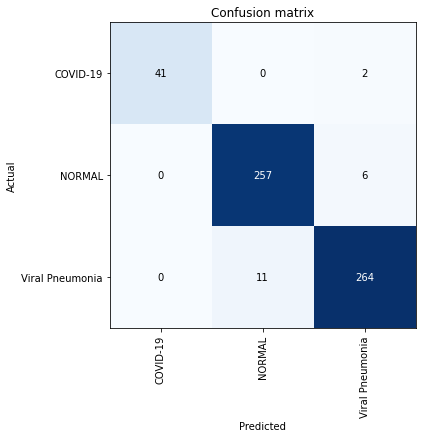

In [52]:
plot_cf(learn)

## Stage - 3
We will now try to reduce the learning rate and see how it progresses.

In [53]:
learn.load("stage-2")
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


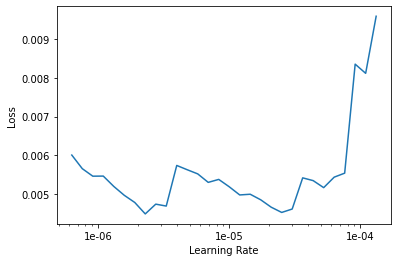

In [54]:
learn.lr_find()
learn.recorder.plot()

In [55]:
learner_callbacks = [callbacks.SaveModelCallback(learn, every='epoch', monitor='accuracy', name='stage-3')]
lr = slice(1e-6,1e-2/(4.3**2))
lr

slice(1e-06, 0.0005408328826392645, None)

In [56]:
learn.fit_one_cycle(3, max_lr=lr, wd=1e-5,callbacks=learner_callbacks)

epoch,train_loss,valid_loss,accuracy,f_beta,precision,recall,time
0,0.010116,0.185030,0.958692,0.957248,0.957204,0.957332,01:30
1,0.007730,0.254889,0.960413,0.964857,0.971763,0.958765,01:29
2,0.010128,0.193457,0.960413,0.957812,0.971741,0.945630,01:29


In [ ]:
learn.save("stage-3")

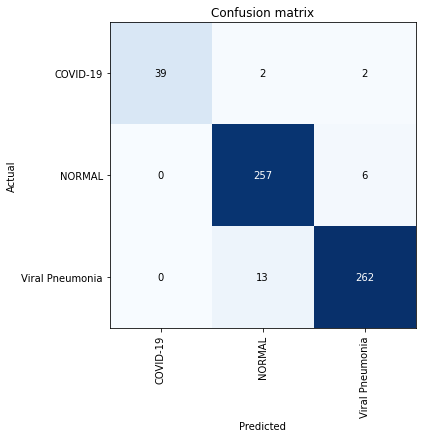

In [57]:
plot_cf(learn)

## Conclusion

Since Stage - 3 had some overfitting issues, we are going to use the stage-2's saved learner for prediction now. 

### Note
**This can further be improved by trying out other CNN architectures and by tweaking model parameters such as learning rate and weight decay and may more.**

**We can also use additional information, if we have, as data points and create a [wide and deep model, another really promising approach](https://ai.googleblog.com/2016/06/wide-deep-learning-better-together-with.html).**

## Take-aways
The metrics observed in just 5 epochs after warm-up gives great result even with not so complex architecture of resnet50. 

## Prediction

In [58]:
!ls -lh "{PROJECT_PATH}"/models

total 2.8G
-rw-r--r-- 1 root root 115M Aug 16 14:51 stage-1.pth
-rw-r--r-- 1 root root 294M Aug 16 14:58 stage-2_0.pth
-rw-r--r-- 1 root root 294M Aug 16 15:00 stage-2_1.pth
-rw-r--r-- 1 root root 294M Aug 16 15:01 stage-2_2.pth
-rw-r--r-- 1 root root 294M Aug 16 15:03 stage-2_3.pth
-rw-r--r-- 1 root root 294M Aug 16 15:04 stage-2_4.pth
-rw-r--r-- 1 root root 294M Aug 16 15:05 stage-2.pth
-rw-r--r-- 1 root root 294M Aug 16 15:10 stage-3_0.pth
-rw-r--r-- 1 root root 294M Aug 16 15:11 stage-3_1.pth
-rw-r--r-- 1 root root 294M Aug 16 15:13 stage-3_2.pth
-rw-r--r-- 1 root root  99M Aug 16 15:06 tmp.pth


### Loading best model to predict

In [59]:
learn.load("stage-2")
print("loaded")

loaded


### Creating Prediction Utils

In [62]:
import cv2

def print_percent(outputs):
  """
  Prints the confidence in the prediction in percentage.
  """
  percent_value = np.around(100 * outputs[outputs.argmax()].numpy(), 4)
  print(f"percent: {percent_value}%")

def predict_from_img(image_path):
  """
  Predicts whether the image is 'NORMAL' or 'COVID-19' or has 'Viral Pneumonia'.
  """
  img = open_image(image_path)
  plt.figure(figsize = (10,10))
  plt.imshow(cv2.imread(image_path))
  pred_class,pred_idx,outputs = learn.predict(img)

  prob_malignant = float(outputs[1])

  print(f"Class: {pred_class}")
  print_percent(outputs)

  learn.predict(img)

### Predicting with NORMAL XRAY Image

In [63]:
!ls -l "{PROJECT_PATH}"/NORMAL/ | head

total 597532
-rw-r--r-- 1 root root 423466 Mar 28 23:36 NORMAL (1000).png
-rw-r--r-- 1 root root 483215 Mar 28 23:36 NORMAL (1001).png
-rw-r--r-- 1 root root 482264 Mar 28 23:36 NORMAL (1002).png
-rw-r--r-- 1 root root 480853 Mar 28 23:36 NORMAL (1003).png
-rw-r--r-- 1 root root 468963 Mar 28 23:36 NORMAL (1004).png
-rw-r--r-- 1 root root 462113 Mar 28 23:36 NORMAL (1005).png
-rw-r--r-- 1 root root 487634 Mar 28 23:36 NORMAL (1006).png
-rw-r--r-- 1 root root 451589 Mar 28 23:36 NORMAL (1007).png
-rw-r--r-- 1 root root 444933 Mar 28 23:36 NORMAL (1008).png


Class: NORMAL
percent: 99.9916%


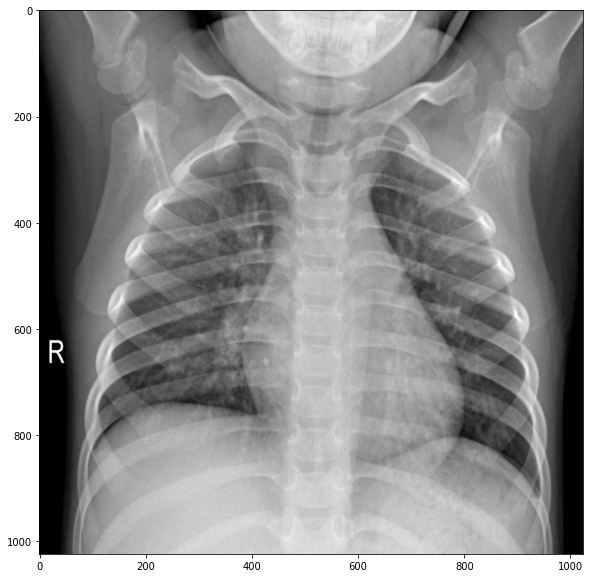

In [64]:
image_path = f"{PROJECT_PATH}/NORMAL/NORMAL (143).png"
predict_from_img(image_path)

### Predicting with COVID-19 XRAY Image

In [65]:
!ls -l "{PROJECT_PATH}"/COVID-19/ | head

total 103132
-rw-r--r-- 1 root root  486060 Mar 28 23:36 COVID-19 (100).png
-rw-r--r-- 1 root root  385319 Mar 28 23:36 COVID-19 (101).png
-rw-r--r-- 1 root root  365041 Mar 28 23:36 COVID-19 (102).png
-rw-r--r-- 1 root root  284341 Mar 28 23:36 COVID-19 (103).png
-rw-r--r-- 1 root root  472752 Mar 28 23:36 COVID-19 (104).png
-rw-r--r-- 1 root root  386392 Mar 28 23:36 COVID-19 (105).png
-rw-r--r-- 1 root root  398579 Mar 28 23:36 COVID-19 (106).png
-rw-r--r-- 1 root root  382903 Mar 28 23:36 COVID-19 (107).png
-rw-r--r-- 1 root root  358338 Mar 28 23:36 COVID-19 (108).png


Class: COVID-19
percent: 100.0%


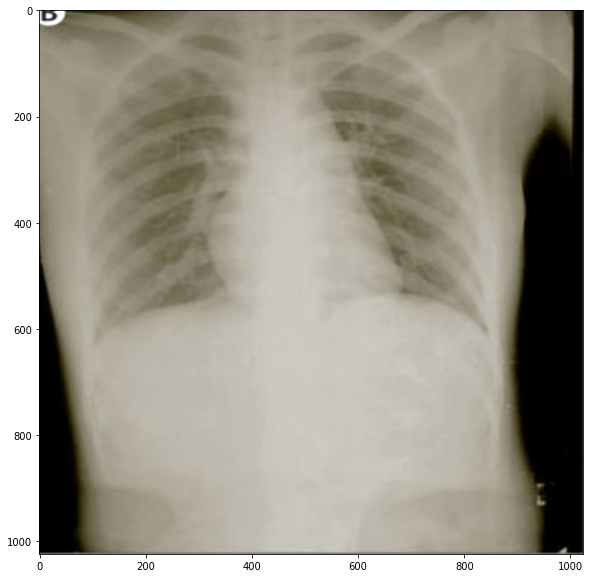

In [66]:
image_path = f"{PROJECT_PATH}/COVID-19/COVID-19 (103).png"
predict_from_img(image_path)

### Predicting with Viral Pneumonia XRAY Image

In [67]:
!ls -l "{PROJECT_PATH}/Viral Pneumonia" | head

total 508624
-rw-r--r-- 1 root root 411159 Mar 28 23:37 Viral Pneumonia (1000).png
-rw-r--r-- 1 root root 392917 Mar 28 23:37 Viral Pneumonia (1001).png
-rw-r--r-- 1 root root 457125 Mar 28 23:37 Viral Pneumonia (1002).png
-rw-r--r-- 1 root root 463242 Mar 28 23:37 Viral Pneumonia (1003).png
-rw-r--r-- 1 root root 452855 Mar 28 23:37 Viral Pneumonia (1004).png
-rw-r--r-- 1 root root 384431 Mar 28 23:37 Viral Pneumonia (1005).png
-rw-r--r-- 1 root root 297885 Mar 28 23:37 Viral Pneumonia (1006).png
-rw-r--r-- 1 root root 374610 Mar 28 23:37 Viral Pneumonia (1007).png
-rw-r--r-- 1 root root 333848 Mar 28 23:37 Viral Pneumonia (1008).png


Class: Viral Pneumonia
percent: 99.9942%


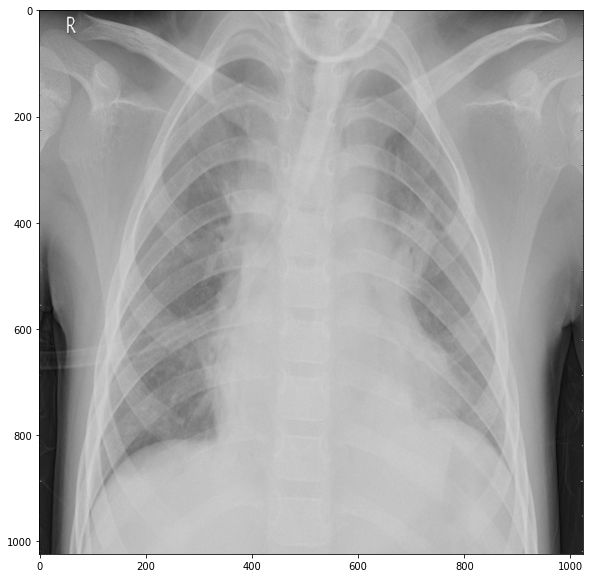

In [68]:
image_path = f"{PROJECT_PATH}/Viral Pneumonia/Viral Pneumonia (1007).png"
predict_from_img(image_path)

## Final Takeaways

In the end, this was a pretty useful and educational exercise. It show cases the power of Computer Vision and Deep Learning. With just ~3000 images, we were able to determine whether a patient is COVID Positive or just has Viral Pneumonia or is NORMAL, which is not easily distinguishable by human eyes.

**Note: Again, this is not a scientifically rigorous study, nor will it be published in a journal and should only be referred to for educational purposes.**

## Thank You